# Module 05: 1-D Advection Dominated Problems – Contaminants in an Aquifer

### 1. Introduction and Background

In this notebook we are going to apply what we have learned about 1-dimensional advection-dominated processes to developing a model of transport of a radioactive contaminant in an aquifer that is at a steady state of regionally dominated groundwater flow. That is, we will assume that the flow velocity is equivalent to the average Darcy flux in the aquifer. Darcy's law specifies that the flux of water at a point in a saturated aquifer can be given by the equation:

$$
q_x = K_{sat}\cdot\frac{\partial h}{\partial x}
$$

where $K_{sat}$ is the saturated hydraulic conductivity – a property of the aquifer materials and the fluid flowing through them; water in this case in units of m/yr, $\partial h/\partial x$ is the gradient of the piezometric surface in units of m/m, and $q_x$ is the flux of water in the $x$ direction. 

We will assume a constant and given value of the gradient of the piezometric surface, which amounts to assuming that there is a large regionally sloping water table and no local influences due to pumping or injection wells, no significant topography that may change the local water table. This is a reasonable assumption in a place like the Snake River Plain in Eastern Idaho at some location that is far from human activities like farming or irrigation. We will also assume that $K_{sat}$ is known and well characterized from, for example, an aquifer pump test or a calibrated model. With these assumption our Darcy velocity $q_x$ is a constant and will become the advection velocity in our advection equation. 

The 1-dimensional advection equation is then given by:

$$
\frac{\partial C}{\partial t} + q_x\frac{\partial C}{\partial x} = 0
$$

where $C$ is the concentration at location $x$ and time $t$ in units of Bq/g. 

### 2. Applying a Numerical Solution

In this problem, we will use the so-called "upwind" solution to the advection equation. The upwind solution approximates the spatial concentration gradient term in the advection equation by taking a finite difference of the concentration at the target location $i$ and the pixel/cell immediately to the left at location $i-1$. The solution is called an upwind scheme because this finite difference approximation assumes that the flow direction is in the __positive__ $x$-direction, and therefore the $i-1$ location is "upwind." If flow is actually from right-to-left then the upwind cell/pixel would be at the $i+1$ location. You can see how this might be problematic if the flow ever switches direction, as in an estuary under the influence of tidal forces or a location with a very small piezometric gradient that can change directions. 

The finite difference approximation to the advection equation in this upwind scheme is given as,

$$
\frac{C_i^{n+1}-C_i^n}{\Delta t} + q_x\frac{C_i^n - C_{i-1}^n}{\Delta x} = 0
$$

Where we desire to solve for the concentration at location $i$ at time level $n+1$ ($C_i^{n+1}$), knowing the concentrations at location $i$ and $i-1$ at time level $n$, $C_i^n$ and $C_{i-1}^n$, respectively. Rearranging terms and solving for $C_i^{n+1}$ yields,

$$
C_i^{n+1} = C_i^n + \left( q_x \frac{\Delta t}{\Delta x} \right) \left(C_{i-1}^n - C_i^n \right)
$$

Note the change in order of the concentration differences from $(C_i^n - C_{i-1}^n)$ to $(C_{i-1}^n - C_i^n)$ to account for the sign change in moving the finite difference approximation to the spatial concentration gradient from the left to the right hand side of the equation. Note that the term $q_x(\Delta t / \Delta x)$ is the so-called Courant number, or the fraction of a spatial step traveled at the advection velocity in a single time step. Unless the Courant number is exactly 1, the solution will experience anomalous ___numerical diffusion.___ You should stop to think about how you would handle the solution of this equation in a flow field where the velocity $q_x$ varies through time! 

### 3. Initial Setup and Creating the Domain

Below, we set the values for the spatial domain, simulation period, aquifer properties, and solve for the Darcy velocity. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt

dx = 5.0 # spatial resolution [m]
dt = 5.0 # temporal resolution [yr]

xmin = 0.0 # Left coordinate of the domain [m]
xmax = 4000.0 # Right coordinate of the domain [m]

t0 = 0.0 # Initial simulation time [yr]
tf = 10000.0 # Final simulation time [yr]

Ks = 15.0 # Saturate hydraylic conductivity [cm/day]
dhdx = 30.0 # Regional piezometric gradient in [ft/mile]

Ks = Ks/100.0*365.25 # Converting Ksat to [m/yr]
dhdx = dhdx*(1/5280.0) # Converting hydraulic gradient to [ft/ft]... do we need to do anything else to convert to [m/m]???

In [2]:
q = Ks*dhdx

print('The Darcy velocity is ' + '{:.3f}'.format(q) + ' [m/yr]')

The Darcy velocity is 0.311 [m/yr]


In [3]:
Courant = q*(dt/dx)

print('The Courant number is ' + '{:.3f}'.format(Courant)+'. The optimal number is 1 to avoid numerical diffusion. Consider changing dt')

The Courant number is 0.311. The optimal number is 1 to avoid numerical diffusion. Consider changing dt


#### 3.1 Setup the Spatial Domain

In [4]:
x = np.arange(xmin+dx/2, xmax, dx)
Nx = x.size

print('The number of cells is: Nx = ' + str(Nx))

The number of cells is: Nx = 800


#### 3.2 Setup the Time Vector

In [5]:
t = np.arange(t0,tf+dt,dt)
Nt = t.size
print('The number of time steps: Nt = ' + str(Nt))

The number of time steps: Nt = 2001


### 4. Setup Initial and Boundary Conditions

In this problem, we will set the initial condition to concentration of 0 GBq/g everywhere except at the left side of the domain, where the concentration will be 1.0 GBq/g (10${}^9$Bq/g). The Becquerel (Bq) is the SI unit of radioactivity of a material and corresponds to the number of particle disintegrations per second. So 1 particle disintegration per second is equivalent to 1 Bq.   

The boundary condition at the left side will be that the concentration is held constant at 1.0 GBq/g throughout the simulation. This corresponds to a condition in which a container of nuclear waste has failed and is leaking at a constant rate and cannot be repaire. 

In [6]:
# Initial condition: concentration is 0 GBq/g everywhere except at x = 0,
# where it is 1 GBq/g
c0 = np.zeros((Nx,1))
c0[0] = 1

# Boundary condition: concentration is 1 GBq/g at x = 0 for all times
csource = 1.0


### 5. Preallocate Container for Solution

In [7]:
C = np.zeros((Nx,Nt))


### 6. Compute Solution

In [8]:
for i in np.arange(Nt):
    
    # Get initial conditions
    if (i==0):
        Cprev = c0
    else:
        Cprev = C[:,i-1]
    
    Cnext = np.zeros((Nx))
    
    for j in np.arange(Nx):
        
        if (j==0):
            Cnext[0] = csource
        else:
            Cnext[j] = Cprev[j] + q*(dt/dx)*(Cprev[j-1] - Cprev[j])
        
    C[:,i] = Cnext

### 7. Plot Solutions

Text(0.5, 0, 'Distance from Source [m]')

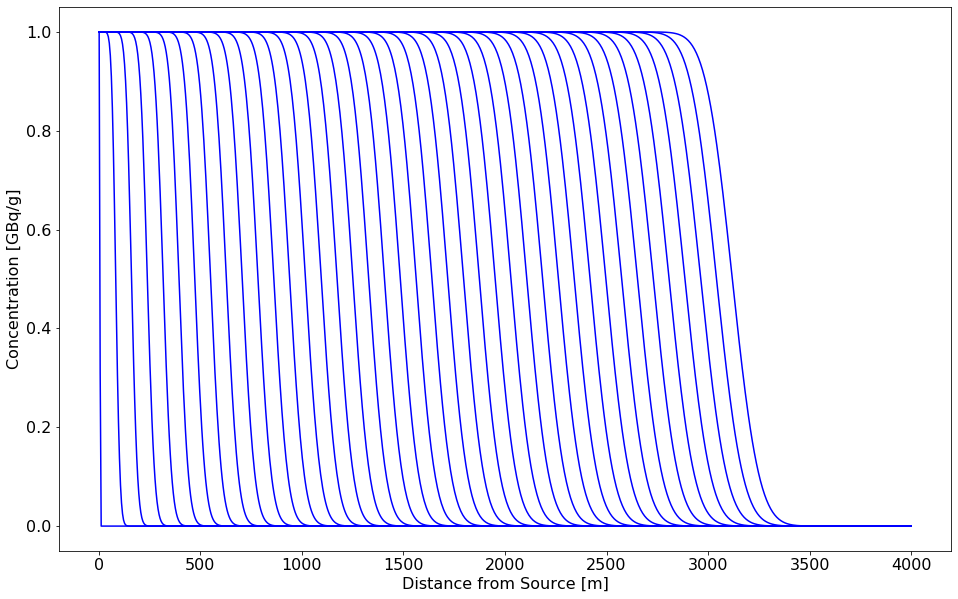

In [9]:
## First off, let's change the font size for all of our plots to be more legible
plt.rcParams.update({'font.size': 16})
plt.figure(figsize=(16,10))

# Plot every 50th concentration curve
for p in np.arange(0,Nt,50):
    plt.plot(x,C[:,p],'b')

plt.ylabel('Concentration [GBq/g]')
plt.xlabel('Distance from Source [m]')


Text(0, 0.5, 'Time [years]')

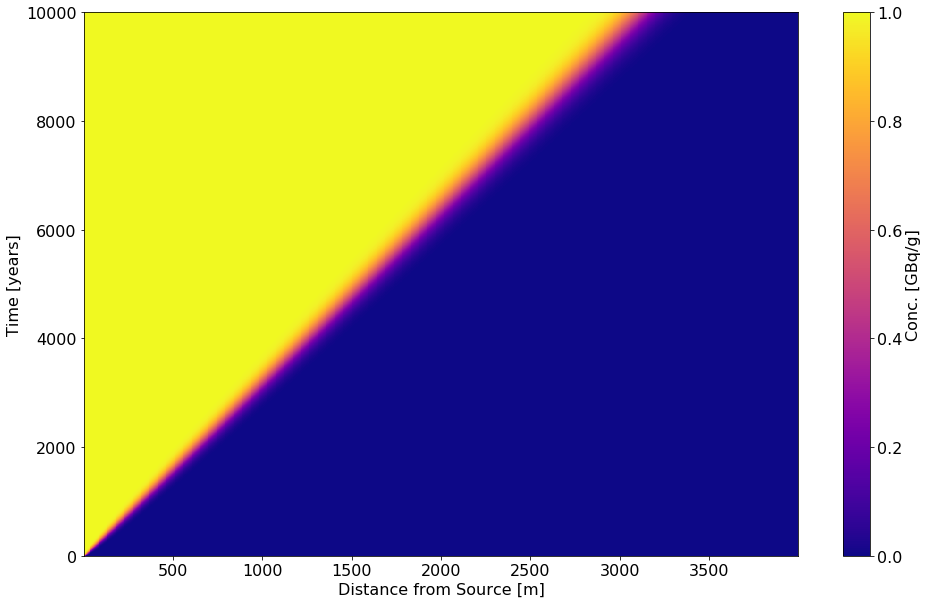

In [10]:
xx,tt = np.meshgrid(t,x)

plt.figure(figsize=(16,10))

plt.pcolormesh(tt,xx,C,cmap='plasma') 
plt.colorbar(label='Conc. [GBq/g]')
plt.xlabel('Distance from Source [m]')
plt.ylabel('Time [years]')


### A Couple of Reflection Questions

The solutions above prompt a little bit of thought. In particular, I'm curious as to your answers to the following questions:

1. Are we encountering numerical diffusion? How do you know and how would you reduce it? 
2. If the velocity was to be variable in time, but given, how would handle trying to keep the Courant number to reasonable values to avoid numerical diffusion? 
3. This simulation lasts 10,000 years for 4 km of aquifer, so this is a relatively slow problem. What process are we missing that is potentially important? Hint: you don't have to be a nuclear physicist, but what is the one number that we use to characterize how long radioactive contaminants like <sup>131</sup>I, <sup>137</sup>Cs, and <sup>90</sup>Sr last in the environment. What does that number mean and where might it appear in our advection equation?  
4. If there was a city that was above the aquifer at 2 km away from the contaminant source, how would we determine when the aquifer would be contaminated? 